# P4 Advanced Lane Lines
## Thomas J. Chmielenski
## September 2017
---

In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available  in this project repository.

More specifically, the goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### 1.  Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.


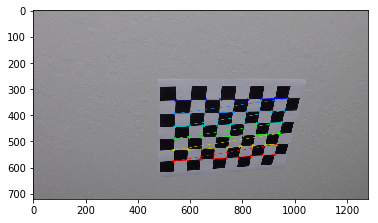

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

def  compute_camera_calibration_coefficents(calibration_images ='./camera_cal/calibration*.jpg', nx = 9, ny =6):
    images = glob.glob(calibration_images)

    # Arrays to store object points and image points from all the images
    objpoints =[] #3D points in real world space
    imgpoints =[] #2D points in image plane

    # Prepare object points, like (0,0, 0), (1,0,0), (2,0,0), ...,  (7,5,0)
    objp = np.zeros((ny * nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) 

    for fname in images:
        # Read om each image
        img = mpimg.imread(fname)
    
        # Convert image to grayscale
        # mpimg.imread() this will read in an RGB image
        # cv2.imread () or glob API this will read in a BGR image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
        # If corners are found, add object points, image points
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
               
            img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
            if (len(objpoints) == 1):                               
                # first out the first image
                plt.imshow(img)
                plt.savefig('./output_images/chessboard.png')
                plt.show()

    # To calibrate a camera
    # gray.shape[::-1] is equivalent to img.shape[0:2] <-- first two values of a color image shape
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return (ret, mtx, dist, rvecs, tvecs)

nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
(ret, mtx, dist, rvecs, tvecs) = compute_camera_calibration_coefficents (calibration_images =  './camera_cal/calibration*.jpg', nx = nx, ny = ny)

dist_pickle = {}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
pickle.dump(dist_pickle, open( "./calibration_pickle.p", "wb"))

# To Undistort
#dst = cv2.undistort(img, mtx, dist, None, mtx)


### 2.  Apply a distortion correction to raw images.

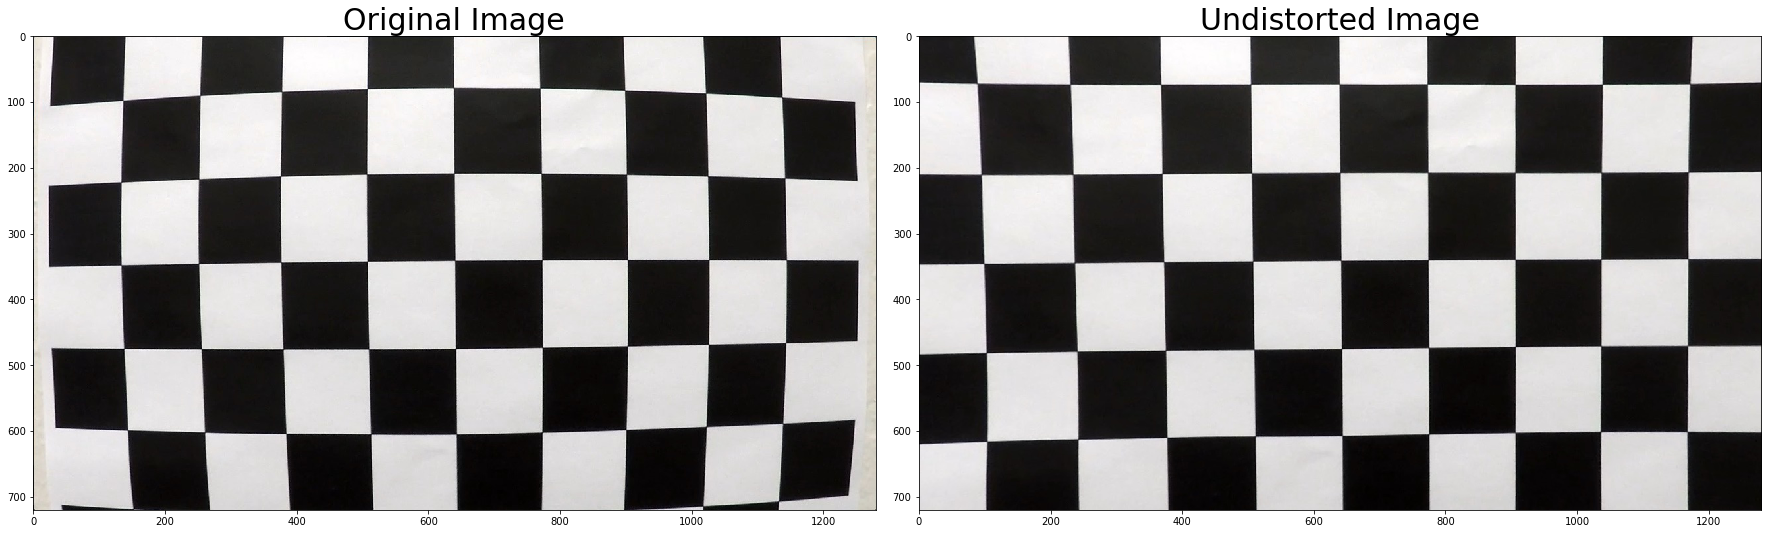

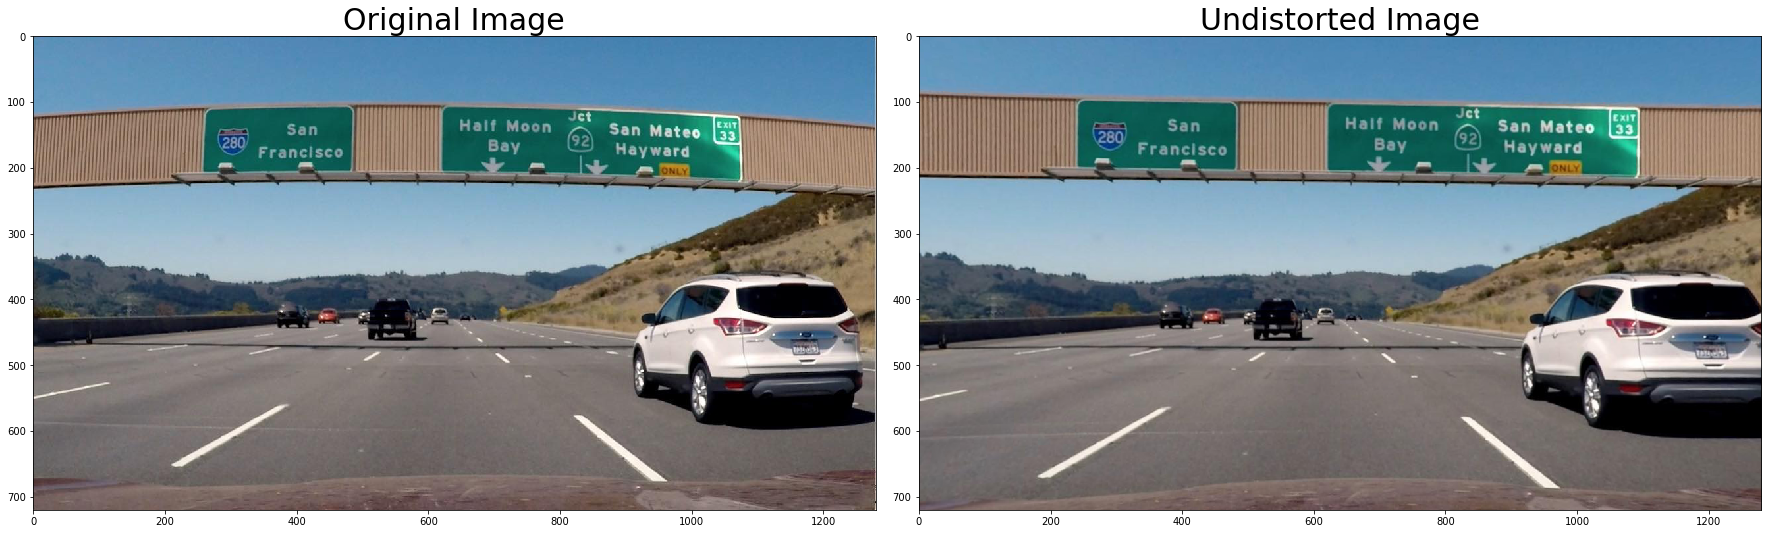

In [2]:
# Plot the result
def plotImage(image, image_cmap=None,  save_filename=None):
    plt.imshow(image,cmap=image_cmap)
    if save_filename:
        plt.savefig(save_filename)
    plt.show()

def plot3images(image1, image2, imge3, title1, title2, title3, 
                image1cmap=None, image2cmap='gray',image3cmap='gray', save_filename=None):
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap=image1cmap)
    ax1.set_title(title1, fontsize= 20)
    ax2.imshow(image2, cmap=image2cmap)
    ax2.set_title(title2, fontsize= 20)
    ax3.imshow(image3, cmap=image1cmap)
    ax3.set_title(title3, fontsize= 20)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if save_filename:
        plt.savefig(save_filename)
    plt.show()

def plot2images(image1, image2, title1, title2, image1cmap=None, image2cmap='gray', save_filename=None):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap=image1cmap)
    ax1.set_title(title1, fontsize= 30)
    ax2.imshow(image2, cmap=image2cmap)
    ax2.set_title(title2, fontsize= 30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    if save_filename:
        plt.savefig(save_filename)
    plt.show()
    
image = mpimg.imread('./camera_cal/calibration1.jpg')
dst = cv2.undistort(image, mtx, dist, None, mtx)
plot2images(image1=image, image2=dst, title1='Original Image', title2='Undistorted Image', save_filename='output_images/orig_vs_undistorted_image.png')

image = mpimg.imread('./examples/signs_vehicles_xygrad.png')
dst = cv2.undistort(image, mtx, dist, None, mtx)
plot2images(image1=image, image2=dst, title1='Original Image', title2='Undistorted Image', save_filename='output_images/orig_vs_undistorted_image2.png')



### 3.  Use color transforms, gradients, etc., to create a thresholded binary image.

Notes:

* RGB matplotlib.image.imread()
* BGR cv2.imread()
* HSV color space (hue, saturation, and value), and 
* HLS space (hue, lightness, and saturation)
* LUV space


In [3]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def apply_region_of_interest_mask(image):
    x_factor = 40
    y_factor = 60
    vertices = np.array([[
        (0,image.shape[0]),
        (((image.shape[1]/2)- x_factor), (image.shape[0]/2)+ y_factor), 
         (((image.shape[1]/2) + x_factor), (image.shape[0]/2)+ y_factor), 
         (image.shape[1],image.shape[0])]], dtype=np.int32)
    #print (vertices)
    return region_of_interest(image, vertices)

In [4]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    #plot2images(image1=image, image2=grad_binary, title1='Original Image', title2='thresholded y-derivative', save_filename='output_images/thresholdedy-derivative.png')

    # Return the result
    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    #plot2images(image1=image, image2=mag_binary, title1='Original Image', title2='Thresholded Magnitude', save_filename='output_images/thresholded_magnitude.png')

    # Return the binary image
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    #plot2images(image1=image, image2=dir_binary, title1='Original Image', title2='Thresholded Direction', save_filename='output_images/thresholded_direction.png')
    return dir_binary

def color_threshold(image, s_thresh=(0, 255), v_thresh=(0, 255)):
    # Convert to HLS
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,1]
    V = hsv[:,:,2]
    
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    v_binary = np.zeros_like(V)
    v_binary[(S > v_thresh[0]) & (V <= v_thresh[1])] = 1
    
    combined = np.zeros_like(S)
    combined[((s_binary == 1) & (v_binary == 1))] = 1
    
    return combined

In [5]:
### various combinations of combinating color and gradients
def combined_color_and_gradient5a(image):
    ksize=15

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(150, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1,3))

    combined = np.zeros_like(image[:,:,0])
    combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    #plot2images(image1=img, image2=combined, title1='Original Image', title2='X, Y, Mag, Dir Threshold 2', save_filename='output_images/combined_xymagdir.png')
   
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    #70 to 80, 255
    s_thresh = (70, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
        
    # lower below 200
    # higher below
    l_thresh = (150, 200)
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1
    
    color_binary = np.zeros_like(S)
    color_binary[((s_binary == 1) | (l_binary == 1))] = 1
    #plot2images(image1=img, image2=color_binary, title1='Original Image', title2='Color Threshold', save_filename='output_images/color.png')
    
   # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack(( np.zeros_like(combined), combined, color_binary)) * 255

    # Combine the two binary thresholds
    both_binary = np.zeros_like(combined)
    both_binary[(combined == 1) | (color_binary == 1)] = 1

    if (False):
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(stacked_binary)
        ax2.set_title('Combined Gradient and Color thresholds')
        ax2.imshow(both_binary, cmap='gray')
        plt.show()
        
    return both_binary

def combined_color_and_gradient5b(image):
    ksize=15

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(150, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1,3))
    c_binary = color_threshold(image, s_thresh=(100, 255), v_thresh=(60, 255))

    combined = np.zeros_like(image[:,:,0])
    combined[((gradx == 1) & (grady == 1) | (c_binary == 1) | (mag_binary == 1))] = 1
    
    return combined

def combined_color_and_gradient5c(image):
    l_channel = cv2.cvtColor(image, cv2.COLOR_BGR2LUV)[:,:,0]

    b_channel = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)[:,:,2]   

    # Threshold color channel
    b_thresh_min = 155
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    l_thresh_min = 225
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    return combined_binary

def combined_color_and_gradient5d(image):
    
    #Don’t use L from HLS. Use only L from LUV and fine tune it with S channel from HSV not HLS.
    LUV = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    L = LUV[:,:,0]
    
    l_thresh = (170,255)
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,1]
    
    s_thresh = (125, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    color_binary = np.zeros_like(S)
    color_binary[((s_binary == 1) | (l_binary == 1))] = 1
    
   # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack(( np.zeros_like(l_binary), l_binary, s_binary)) * 255
    #plot2images(image1=img, image2=stacked_binary, title1='Original Image', title2='Color Threshold - LUV and HSV', save_filename='output_images/color_luv_hsv.png')

    return color_binary

def combined_color_and_gradient5e(image):
    
    #Don’t use L from HLS. Use only L from LUV and fine tune it with S channel from HSV not HLS.
    LUV = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    L = LUV[:,:,0]
    
    l_thresh = (170, 200)
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,1]
    
    s_thresh = (75, 205)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    color_binary = np.zeros_like(S)
    color_binary[((s_binary == 1) | (l_binary == 1))] = 1

    return color_binary
 
def combined_color_and_gradient5f(image):
    ksize=15

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(150, 255))
    dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1,3))
    #c_binary = color_threshold(image, s_thresh=(100, 255), v_thresh=(60, 255))

    #combined = np.zeros_like(image[:,:,0])
    #combined[((gradx == 1) & (grady == 1) | (c_binary == 1) | (mag_binary == 1))] = 1
    
    LUV = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    L = LUV[:,:,0]
    
    l_thresh = (170, 200)
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,1]
    
    s_thresh = (75, 205)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    color_binary = np.zeros_like(S)
    color_binary[((s_binary == 1) | (l_binary == 1))] = 1
    
    combined = np.zeros_like(image[:,:,0])
    combined[((gradx == 1) & (grady == 1) | (color_binary == 1) | (mag_binary == 1))] = 1

    return combined


#used by 5g
def sobel_xg(img, sobel_kernel=9,min_thres = 80, max_thres =220):
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    sobelx1 = cv2.Sobel(L, cv2.CV_64F, 1,0, ksize=sobel_kernel)
    sobelx2 = cv2.Sobel(S, cv2.CV_64F, 1,0, ksize=sobel_kernel)
        
    scaled_sobelx1 = np.uint8(255*sobelx1/ np.max(sobelx1))
    scaled_sobelx2 = np.uint8(255*sobelx2/ np.max(sobelx2))

    binary_outputx1 = np.zeros_like(scaled_sobelx1)
    binary_outputx1[(scaled_sobelx1 >= min_thres) & (scaled_sobelx1 <= max_thres)] = 1

    binary_outputx2 = np.zeros_like(scaled_sobelx2)
    binary_outputx2[(scaled_sobelx2 >= min_thres) & (scaled_sobelx2 <= max_thres)] = 1

    binary_output = np.zeros_like(scaled_sobelx1)
    binary_output[(binary_outputx1 ==1) | (binary_outputx2 ==1)]=1
    
    return binary_output

def combined_color_and_gradient5g(image):
    ksize=9

    #gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    #grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    #mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(150, 255))
    #dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1,3))
    #c_binary = color_threshold(image, s_thresh=(100, 255), v_thresh=(60, 255))

    gradx = sobel_xg(image, sobel_kernel=ksize,min_thres = 80, max_thres = 200)
    #combined = np.zeros_like(image[:,:,0])
    #combined[((gradx == 1) & (grady == 1) | (c_binary == 1) | (mag_binary == 1))] = 1
    
    LUV = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
    L = LUV[:,:,0]
    
    l_thresh = (170, 200)
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1

    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,1]
    
    s_thresh = (75, 205)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    color_binary = np.zeros_like(S)
    color_binary[((s_binary == 1) | (l_binary == 1))] = 1
    
    combined = np.zeros_like(image[:,:,0])
    #combined[((gradx == 1) & (grady == 1) | (color_binary == 1) | (mag_binary == 1))] = 1
    combined[((gradx == 1)  | (color_binary == 1) )] = 1

    return combined

# used with 5h
def hsv_color_thresh(img, threshLow, threshHigh):
    # 1) Convert to HLS color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
   
    # 3) Return a binary image of threshold result
    binary_output = np.zeros((img.shape[0], img.shape[1]))
    binary_output[(hsv[:,:,0] >= threshLow[0]) & (hsv[:,:,0] <= threshHigh[0]) & 
                  (hsv[:,:,1] >= threshLow[1])  & (hsv[:,:,1] <= threshHigh[1])  & 
                  (hsv[:,:,2] >= threshLow[2]) & (hsv[:,:,2] <= threshHigh[2])] = 1
                 
    return binary_output
    
def combined_color_and_gradient5h(image):
    yellow_low = np.array([0,100,100])
    yellow_high = np.array([50,255,255])
    white_low = np.array([18,0,180])
    white_high = np.array([255,80,255])
    
    imgThres_yellow = hsv_color_thresh(image,yellow_low,yellow_high)
    imgThres_white = hsv_color_thresh(image,white_low,white_high)
    
    imgThres_both =np.zeros_like(imgThres_yellow)
    imgThres_both[(imgThres_yellow==1) | (imgThres_white==1)] =1
    
    gradx = sobel_xg(image, sobel_kernel=9,min_thres = 80, max_thres = 200)
    
    combined = np.zeros_like(image[:,:,0])
    combined[((gradx == 1)  | (imgThres_both == 1) )] = 1

    return combined

def combined_color_and_gradient(image):
    #combined = combined_color_and_gradient5a(image)
    #combined = combined_color_and_gradient5b(image)
    combined = combined_color_and_gradient5d(image) #best
    #combined = combined_color_and_gradient5e(image)
    #combined = combined_color_and_gradient5f(image) #best
    #combined = combined_color_and_gradient5g(image)
    #combined = combined_color_and_gradient5h(image)

    return combined


images = glob.glob('./test_frame_images/frame_20.jpg')
for idx, fname in enumerate(images):
    print (fname)
    # read in image
    img =  mpimg.imread(fname)
    
    undistort = cv2.undistort(img, mtx, dist, None, mtx)

    combined = combined_color_and_gradient (undistort)
    
    img2 = apply_region_of_interest_mask(combined)
    
    #plot2images(image1=img, image2=img2, title1='Original Image', title2='Combined Thresholds', save_filename='output_images/combined_thresholds.png')

./test_frame_images/frame_20.jpg


### 4.  Apply a perspective transform to rectify binary image ("birds-eye view").


In [6]:
def create_birds_eye(img, visualize = False):
    img_size = (img.shape[1], img.shape[0])
    
    # 76 08, 62 935, 25
    bottom_width = .76       # percent of bottom trapizoid height
    middle_width = .08       # percent of middle trapizoid height
    height_percentage = .62  # percent of the trapezoid height
    bottom_trim = .935        # percent from top to bottom to avoid car hood
    
    src = np.float32([[img.shape[1]*(.5-middle_width/2), img.shape[0]*height_percentage],
                      [img.shape[1]*(.5+middle_width/2), img.shape[0]*height_percentage],
                      [img.shape[1]*(.5+bottom_width/2), img.shape[0]*bottom_trim],
                      [img.shape[1]*(.5-bottom_width/2), img.shape[0]*bottom_trim]
                     ])
    offset = img_size[0]*.25
    dst = np.float32([[offset, 0], 
                  [img_size[0]-offset, 0], 
                  [img_size[0]-offset, img_size[1]],
                  [offset, img_size[1]]])

    #Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)

    #Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)

    #Warp an image using the perspective transform, M:
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    if (visualize):
        dst_image = np.copy(warped)
        src_int = np.array(src, np.int32)
        dst_int = np.array(dst, np.int32)
        print ('src=', src_int)
        print ('dst=', dst_int)
        pt0 = tuple(dst_int[0])
        pt1= tuple(dst_int[1])
        pt2 = tuple(dst_int[2])
        pt3 = tuple(dst_int[3])

        cv2.line(dst_image, pt0, pt3, (255,0,0), 5)
        cv2.line(dst_image, pt1, pt2, (255,0,0), 5)

        imageName = 'src_dst'+str(idx)+'.jpg'
        #imageName = 'src_dst_curved'+'.jpg'
        #plot2images(image1=img, image2=dst_image, title1='Original w/ src', title2='Warped w/ dst',  save_filename='./output_images/'+ imageName)
    
    return Minv, warped
    
#images = glob.glob('./test_images/straight_lines*.jpg')
images = glob.glob('./test_frame_images/frame_05.jpg')
for idx, fname in enumerate(images):
    # read in image
    img =  mpimg.imread(fname)
    
    undistort = cv2.undistort(img, mtx, dist, None, mtx)

    Minv, warped = create_birds_eye(undistort, visualize = True)
    
       


src= [[ 588  446]
 [ 691  446]
 [1126  673]
 [ 153  673]]
dst= [[320   0]
 [960   0]
 [960 720]
 [320 720]]


### 5.  Detect lane pixels and fit to find the lane boundary.

In [7]:
# Line Finding Method: Peaks in a Histogram
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

#  From Section 33. Finding the Lines from P4: Advance Lane Finding
# Implement Sliding Windows and Fit a Polynomial

def initial_sliding_windows_polyfit (binary_warped, visualize = False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 80
    
    # Set minimum number of pixels found to recenter window
    minpix = 40
    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    found_left_fit, found_right_fit = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        found_left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        found_right_fit = np.polyfit(righty, rightx, 2)
    
    if (visualize):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = found_left_fit[0]*ploty**2 + found_left_fit[1]*ploty + found_left_fit[2]
        right_fitx = found_right_fit[0]*ploty**2 + found_right_fit[1]*ploty + found_right_fit[2]
        ###left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        ###right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    return found_left_fit, found_right_fit, left_lane_inds, right_lane_inds

#images = glob.glob('./test_images/straight_lines1.jpg')
#images = glob.glob('./test_images/straight_lines*.jpg')
#images = glob.glob('./test_images/test*.jpg')
#images = glob.glob('./test_frame_images/frame_*.jpg')
#images = glob.glob('./test_frame_images/frame_22.jpg')
for idx, fname in enumerate(images):
    # read in image
    print(fname)
    img =  mpimg.imread(fname)
     
    undistort = np.copy(img)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    combined = combined_color_and_gradient(undistort)
    
    masked = apply_region_of_interest_mask(combined)
    
    Minv, warped = create_birds_eye (masked, visualize = False)
    
    found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = initial_sliding_windows_polyfit (warped, visualize = False)


./test_frame_images/frame_05.jpg


In [8]:
def polyfit_using_previous_fit(binary_warped, left_fit, right_fit, visualize=False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    margin = 80
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    ###left_fit = np.polyfit(lefty, leftx, 2)
    ###right_fit = np.polyfit(righty, rightx, 2)

    found_left_fit, found_right_fit = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        found_left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        found_right_fit = np.polyfit(righty, rightx, 2)


    if (visualize):
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        ###left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        ###right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_fitx = found_left_fit[0]*ploty**2 + found_left_fit[1]*ploty + found_left_fit[2]
        right_fitx = found_right_fit[0]*ploty**2 + found_right_fit[1]*ploty + found_right_fit[2]

        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
        
    return found_left_fit, found_right_fit, left_lane_inds, right_lane_inds

#images = glob.glob('./test_images/straight_lines1.jpg')
#images = glob.glob('./test_images/straight_lines*.jpg')
#images = glob.glob('./test_images/test*.jpg')
#images = glob.glob('./test_frame_images/frame_*.jpg')
images = glob.glob('./test_frame_images/frame_1*.jpg')
for idx, fname in enumerate(images):
    # read in image
    print(fname)
    img =  mpimg.imread(fname)
     
    undistort = np.copy(img)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    combined = combined_color_and_gradient(undistort)
    
    masked = apply_region_of_interest_mask(combined)
    
    Minv, warped = create_birds_eye (masked, visualize = False)
    
    if (idx == 0):
        found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = initial_sliding_windows_polyfit (warped, visualize = False)
    else:
        found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = polyfit_using_previous_fit(warped, found_left_fit, found_right_fit, visualize=False)


./test_frame_images\frame_10.jpg
./test_frame_images\frame_11.jpg
./test_frame_images\frame_12.jpg
./test_frame_images\frame_13.jpg


### 6.  Determine the curvature of the lane and vehicle position with respect to center.

In [9]:
def radius_of_curvature(binary_image, left_fit, right_fit, l_lane_inds, r_lane_inds):

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    img_size = (binary_image.shape[1], binary_image.shape[0])
   
    #h = binary_image.shape[0]
    ploty = np.linspace(0, img_size[1]-1, img_size[1])
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    # Define conversions in x and y from pixels space to meters
    ###RESUBMIT
    # 70ft  dashed space + dashed line + dashed space
    ym_per_pix = 21.34/385    # meters per pixel in y dimension 
    # 12ft lane in 500 pixels 
    xm_per_pix = 3.7/500      # meters per pixel in y dimension 
    ### ym_per_pix = 30/720 # # meters per pixel in y dimension 
    ### xm_per_pix = 3.7/700 # meters per pixel in x dimension
    ###RESUBMIT - END
    
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    avg_curverad = (left_curverad + right_curverad) / 2
    
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

    dist_from_center = 0.0
    # assume the camera is centered in the vehicle
    ###camera_pos = img_size[1] / 2
    if right_fit is not None:
        if left_fit is not None:
            #  Assume the center of camera frame is directly in the center of the vehicle
            ###RESUBMIT 
            ###camera_pos = img_size[1] / 2
            camera_pos = img_size[0] / 2
            ###RESUBMIT - END
            
            # find where the right and left lanes intersect the bottom of the frame
            left_lane_pix = np.polyval(left_fit, img_size[0])
            right_lane_pix = np.polyval(right_fit, img_size[0])
            center_of_lane_pix = (left_lane_pix + right_lane_pix) / 2
            dist_from_center = (camera_pos - center_of_lane_pix) * xm_per_pix
            #print(dist_from_center, 'm')

    return  avg_curverad, dist_from_center

#images = glob.glob('./test_images/straight_lines1.jpg')
#images = glob.glob('./test_images/straight_lines*.jpg')
#images = glob.glob('./test_images/test*.jpg')
#images = glob.glob('./test_frame_images/frame_*.jpg')
images = glob.glob('./test_frame_images/frame_22.jpg')
for idx, fname in enumerate(images):
    # read in image
    print(fname)
    img =  mpimg.imread(fname)
     
    undistort = np.copy(img)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    combined = combined_color_and_gradient(undistort)
    
    masked = apply_region_of_interest_mask(combined)
    
    Minv, warped = create_birds_eye (masked, visualize = False)
    
    if (idx == 0):
        found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = initial_sliding_windows_polyfit (warped, visualize = False)
    else:
        found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = polyfit_using_previous_fit(warped,found_left_fit, found_right_fit, visualize=True)

    avg_curverad, dist_from_center = radius_of_curvature(warped, found_left_fit, found_right_fit, left_lane_inds, right_lane_inds)
    

./test_frame_images/frame_22.jpg


### 7.  Warp the detected lane boundaries back onto the original image.

In [10]:
def warp_lane_boundaries_back(undist, warped, Minv, left_fit, right_fit):
    
    h = warped.shape[0]
    ploty = np.linspace(0, h-1, h)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # add red left lane line, and blue right lane line
    #cv2.polylines(color_warp, np.int32([pts_left]), isClosed = False, color = (255,0,0), thickness = 20)
    #cv2.polylines(color_warp, np.int32([pts_right]), isClosed = False, color = (0,0,255), thickness = 20)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result


#images = glob.glob('./test_images/straight_lines1.jpg')
#images = glob.glob('./test_images/straight_lines*.jpg')
#images = glob.glob('./test_images/test*.jpg')
#images = glob.glob('./test_frame_images/frame_*.jpg')
#images = glob.glob('./test_frame_images/frame_22.jpg')
for idx, fname in enumerate(images):
    # read in image
    img =  mpimg.imread(fname)
     
    undistort = np.copy(img)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    combined = combined_color_and_gradient(undistort)
    
    masked = apply_region_of_interest_mask(combined)
    
    Minv, warped = create_birds_eye (masked, visualize = False)
    
    if (idx == 0):
        found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = initial_sliding_windows_polyfit (warped, visualize = False)
    else:
        found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = polyfit_using_previous_fit(warped, found_left_fit, found_right_fit, visualize = False)

    avg_curverad, dist_from_center = radius_of_curvature(warped, found_left_fit, found_right_fit, left_lane_inds, right_lane_inds)
    
    lane_image = warp_lane_boundaries_back(undistort, warped, Minv, found_left_fit, found_right_fit)
    
    visualize = False
    if (visualize):
        imageName = 'lanelines'+str(idx)+'.jpg'
        plot2images(image1=img, image2=lane_image, title1='Original Image', title2='With Lane Lines', save_filename='./output_images/'+ imageName)


### 8.  Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [11]:
def overlay_text_on_image (image, avg_curverad, dist_from_center):
    
    new_img = np.copy(image)
    #h = new_img.shape[0]
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_color = (255,255,255)
    
    num_format = '{:04.2f}'
    text = 'Radius of Curvature: ' + num_format.format(avg_curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, font_color, 2, cv2.LINE_AA)
    
    direction = 'left'
    if dist_from_center > 0:
        direction = 'right'
    abs_dist = abs(dist_from_center)
    text = 'Vehicle is ' + num_format.format(abs_dist) + ' m ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, font_color, 2, cv2.LINE_AA)
    
    return new_img


#images = glob.glob('./test_images/straight_lines1.jpg')
#images = glob.glob('./test_images/straight_lines*.jpg')
#images = glob.glob('./test_images/test*.jpg')
#images = glob.glob('./test_frame_images/frame_*.jpg')
images = glob.glob('./test_frame_images/frame_37.jpg')
for idx, fname in enumerate(images):
    # read in image
    img =  mpimg.imread(fname)
     
    undistort = np.copy(img)
    undistort = cv2.undistort(img, mtx, dist, None, mtx)
    
    combined = combined_color_and_gradient(undistort)
    
    masked = apply_region_of_interest_mask(combined)
    
    Minv, warped = create_birds_eye (masked, visualize = False)
    
    if (idx == 0):
        left_fit, right_fit, left_lane_inds, right_lane_inds = initial_sliding_windows_polyfit (warped, visualize = False)
    else:
        left_fit, right_fit, left_lane_inds, right_lane_inds = polyfit_using_previous_fit(warped, left_fit, right_fit, visualize = False)

    avg_curverad, dist_from_center = radius_of_curvature(warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    lane_image = warp_lane_boundaries_back(undistort, warped, Minv, left_fit, right_fit)
        
    result = overlay_text_on_image (lane_image, avg_curverad, dist_from_center)
    
    visualize = False
    if (visualize):
        imageName = 'lanelines2'+str(idx)+'.jpg'
        plot2images(image1=img, image2=result, title1='Original Image', title2='Processed Image', save_filename='./output_images/'+ imageName)


### Process Project Videos

In [12]:
def process_image(image):
     # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    global gLast_Left_Fit 
    global gLast_Right_Fit
    global gInitialBlind
    #global gFrameCounter 
    
    #gFrameCounter += 1
    #print (gFrameCounter)
    
    new_image = np.copy(image)
    undistort = cv2.undistort(new_image, mtx, dist, None, mtx)
    
    combined = combined_color_and_gradient(undistort)
    
    masked = apply_region_of_interest_mask(combined)
    
    Minv, warped = create_birds_eye (masked, visualize = False)
    
    #found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = initial_sliding_windows_polyfit (warped, visualize = False)
    #avg_curverad, dist_from_center = radius_of_curvature(warped, left_fit, right_fit, left_lane_inds, right_lane_inds)
    #lane_image = warp_lane_boundaries_back(undistort, warped, Minv, left_fit, right_fit)
    #
    #result = overlay_text_on_image (lane_image, avg_curverad, dist_from_center)
    
    if (gInitialBlind):
        ##print("Initial Blind")
        found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = initial_sliding_windows_polyfit (warped, visualize = False)
        gInitialBlind = False
    else:
        found_left_fit, found_right_fit, left_lane_inds, right_lane_inds = polyfit_using_previous_fit(warped, gLast_Left_Fit, gLast_Right_Fit, visualize = False)
    
    #print(found_left_fit, found_right_fit)
    
    if (found_left_fit is None) or (found_right_fit is None):
        #print("Reset to Initial Blind: ", gFrameCounter)
        gInitialBlind = True
        found_left_fit = gLast_Left_Fit
        found_right_fit= gLast_Right_Fit
    else:
        gLast_Left_Fit = found_left_fit
        gLast_Right_Fit = found_right_fit
        
    if (gLast_Left_Fit is not None) and (gLast_Right_Fit is not None):
        avg_curverad, dist_from_center = radius_of_curvature(warped, gLast_Left_Fit, gLast_Right_Fit, left_lane_inds, right_lane_inds)
    
        lane_image = warp_lane_boundaries_back(undistort, warped, Minv, gLast_Left_Fit, gLast_Right_Fit)
    
        result = overlay_text_on_image (lane_image, avg_curverad, dist_from_center)
    else:
        result = new_image

    return result

In [13]:
### Test on Videos
import os
import numpy as np

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

def ensure_dir_exists(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)

#def process_image(image):
#    # NOTE: The output you return should be a color image (3 channel) for processing video below
#    # TODO: put your pipeline here,
#    # you should return the final output (image where lines are drawn on lanes)
#   result = find_lanes_advanced(image)
#    return result


In [14]:
gLast_Left_Fit = None
gLast_Right_Fit = None
gInitialBlind = True
#gFrameCounter = 0

#  Testing of project_video.mp4
output_video = 'output_videos/project_video_output.mp4'
clip1 = VideoFileClip("./project_video.mp4")
#clip1 = VideoFileClip("./project_video.mp4").subclip(19,25)
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()



[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [02:41<00:00,  8.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

Wall time: 2min 42s


In [ ]:
#  Testing of challenge_video.mp4
output_video = 'output_videos/challenge_video_output.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)
clip1.reader.close()
clip1.audio.reader.close_proc()


In [ ]:
#  Testing of harder_challenge_video.mp4
output_video = 'output_videos/harder_challenge_video_output.mp4'
clip1 = VideoFileClip("./harder_challenge.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output_video, audio=False)

### Appendix A: Save frames of Video

In [ ]:
output_video = 'output_videos/project_video_output.mp4'
ensure_dir_exists('./output_videos')
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip1 = VideoFileClip("./project_video.mp4").subclip(0,50)


for t in range (1, 50, 1):
    filename = './test_frame_images/frame_' + str(t) + '.jpg'
    clip1. save_frame(filename, t=t, withmask=True)
    
    
clip1.reader.close()
clip1.audio.reader.close_proc()


### Appendix B:  More Threshold Exploration


In [ ]:
def combined_color_and_gradient6(image):
    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L = LUV[:,:,0]
    
    l_thresh = (170, 255)
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1

    HSV = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    S = hsv[:,:,1]
    
    s_thresh = (125, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    color_binary = np.zeros_like(S)
    color_binary[((s_binary == 1) | (l_binary == 1))] = 1
    plot2images(image1=img, image2=color_binary, title1='Original Image', title2='Color Threshold', save_filename='output_images/color.png')
    return color_binary

#Don’t use L from HLS. Use only L from LUV and fine tune it with S channel from HSV not HLS.

def combined_color_and_gradient5(image):
    ksize=11

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(150, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1,3))

    combined = np.zeros_like(image[:,:,0])
    combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    #plot2images(image1=img, image2=combined, title1='Original Image', title2='X, Y, Mag, Dir Threshold 2', save_filename='output_images/combined_xymagdir.png')
   
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    s_thresh = (225, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Convert to HSV
    #hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    #V = hsv[:,:,2]
    
    #v_thresh = (210, 255)
    #v_binary = np.zeros_like(V)
    #v_binary[(S > v_thresh[0]) & (V <= v_thresh[1])] = 1
    #color_binary = np.zeros_like(S)
    #color_binary[((s_binary == 1) & (v_binary == 1))] = 1
    
    l_thresh = (220, 255)
    l_binary = np.zeros_like(L)
    l_binary[(L > l_thresh[0]) & (L <= l_thresh[1])] = 1
    
    color_binary = np.zeros_like(S)
    color_binary[((s_binary == 1) | (l_binary == 1))] = 1
    #plot2images(image1=img, image2=color_binary, title1='Original Image', title2='Color Threshold', save_filename='output_images/color.png')
    
   # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack(( np.zeros_like(combined), combined, color_binary)) * 255

    # Combine the two binary thresholds
    both_binary = np.zeros_like(combined)
    both_binary[(combined == 1) | (color_binary == 1)] = 1

    if (False):
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(stacked_binary)
        ax2.set_title('Combined Gradient and Color thresholds')
        ax2.imshow(both_binary, cmap='gray')
        plt.show()
        
    #return combined
    return color_binary
    #return both_binary
    
def combined_color_and_gradient4(image):
    ksize=7

    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(12, 255))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(150, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1,3))

    combined = np.zeros_like(image[:,:,0])
    combined[((gradx == 1) & (grady == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    #plot2images(image1=img, image2=combined, title1='Original Image', title2='X, Y, Mag, Dir Threshold 2', save_filename='output_images/combined_xymagdir.png')
   
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    s_thresh = (90, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    V = hsv[:,:,2]
    
    v_thresh = (210, 255)
    v_binary = np.zeros_like(V)
    v_binary[(S > v_thresh[0]) & (V <= v_thresh[1])] = 1
    
    color_binary = np.zeros_like(S)
    color_binary[((s_binary == 1) | (v_binary == 1))] = 1
    #plot2images(image1=img, image2=color_binary, title1='Original Image', title2='Color Threshold', save_filename='output_images/color.png')
    
   # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack(( np.zeros_like(combined), combined, color_binary)) * 255

    # Combine the two binary thresholds
    both_binary = np.zeros_like(combined)
    both_binary[(combined == 1) | (color_binary == 1)] = 1

    if (False):
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(stacked_binary)
        ax2.set_title('Combined Gradient and Color thresholds')
        ax2.imshow(both_binary, cmap='gray')
        plt.show()
        
    #return combined
    #    return color_binary
    return both_binary
    

def combined_color_and_gradient3(img):
    kernel_size = 9
    
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=kernel_size, thresh=(50,255))
    #grady = abs_sobel_thresh(img, orient='y', sobel_kernel=11, thresh=(100, 255))
    mag_binary = mag_thresh(img, sobel_kernel=kernel_size, mag_thresh=(150, 255))
    dir_binary = dir_threshold(img, sobel_kernel=kernel_size, thresh=(0.7, 1,3))
    
    combined = np.zeros_like(img[:,:,0])
    combined[((gradx == 1) ) | ((mag_binary == 1) & (dir_binary == 1))] = 1
   
    #plot2images(image1=img, image2=combined, title1='Original Image', title2='X, Y, Mag, Dir Thresholds', save_filename='output_images/combined_xymagdir.png')

    LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    L = LUV[:,:,0]
    
    thresh = (170, 255)
    l_binary = np.zeros_like(L)
    l_binary[(L > thresh[0]) & (L <= thresh[1])] = 1

    s_thresh = (155, 200)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    S = hls[:,:,1]
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    color_binary = np.zeros_like(l_binary)
    color_binary[(l_binary == 1) | (s_binary == 1)] = 1

    #plot2images(image1=img, image2=color_binary, title1='Original Image', title2='Color Threshold', save_filename='output_images/color.png')
 
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    stacked_binary = np.dstack(( np.zeros_like(combined), combined, color_binary)) * 255

    # Combine the two binary thresholds
    both_binary = np.zeros_like(combined)
    both_binary[(combined == 1) | (color_binary == 1)] = 1

    if (False):
        # Plotting thresholded images
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(stacked_binary)
        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(both_binary, cmap='gray')
        plt.show()
        
    return both_binary

def combined_color_and_gradient(image):    
    ksize=3
    preprocessImage = np.zeros_like(image[:,:,0])
    
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(50, 150))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(25, 255))
    
    # Convert to HLS
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    
    s_thresh = (50, 255)
    s_binary = np.zeros_like(S)
    s_binary[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    V = hsv[:,:,2]
    
    v_thresh=(200,255)
    v_binary = np.zeros_like(V)
    v_binary[(S > v_thresh[0]) & (V <= v_thresh[1])] = 1
    
    combined = np.zeros_like(S)
    combined[((s_binary == 1) & (v_binary == 1))] = 1
    
    preprocessImage = np.zeros_like(S)
    preprocessImage[((gradx == 1) & (grady == 1)  |(combined == 1))] = 1 
    
    return preprocessImage

images = glob.glob('./test_frame_images/frame_02.jpg')

for idx, fname in enumerate(images):
    # read in image
    img =  mpimg.imread(fname)
    
    # undistort the image
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    #combined = combined_color_and_gradient(img)
    img = apply_region_of_interest_mask(img)
    img2 = np.copy(img)
    combined = combined_color_and_gradient6(img2)
    #plot2images(image1=img, image2=combined, title1='Original Image', title2='Combined Thresholds', save_filename='output_images/combined_thresholds.png')


In [ ]:
if (False):
    #images = glob.glob('./test_frame_images/frame_*.jpg')
    #images = glob.glob('./test_frame_images/frame_45.jpg')
    #images = glob.glob('./examples/signs_vehicles_xygrad.png')
    #images = glob.glob('./examples/bridge_shadow.png')
    #images = glob.glob('./examples/color-shadow-example.png')
    #images = glob.glob('./examples/*shadow*.jpg')
    images = glob.glob('./test_frame_images/frame_2*.jpg')
    
    for idx, fname in enumerate(images):
        # read in image
        img =  mpimg.imread(fname)

        # undistort the image
        img = cv2.undistort(img, mtx, dist, None, mtx)

        #thresh = (180, 255)
        #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        #binary = np.zeros_like(gray)
        #binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
        #plot2images(image1=gray, image2=binary, 
        #            image1cmap='gray', image2cmap='gray',
        #            title1='Gray', title2='Binary Gray', 
        #            save_filename='output_images/color_gray.png')

        #R = img[:,:,0]
        #G = img[:,:,1]
        #B = img[:,:,2]
        #plot2images(image1=R, image2=binary, 
        #            image1cmap='gray', image2cmap='gray',
        #            title1='R Channel', title2='R Binary', 
        #            save_filename='output_images/color_red.png')
        #thresh = (200, 255)
        #binary = np.zeros_like(R)
        #binary[(R > thresh[0]) & (R <= thresh[1])] = 1
        #plot2images(image1=R, image2=binary, 
        #            image1cmap='gray', image2cmap='gray',
        #            title1='R Channel', title2='R Binary', 
        #            save_filename='output_images/color_red.png')

        LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        L = LUV[:,:,0]
        U = LUV[:,:,1]
        V = LUV[:,:,2]
        plot3images(image1=L, image2=U, image3=V, 
                    image1cmap='gray', image2cmap='gray', image3cmap='gray',
                    title1='L', title2='U', title3='V',
                    save_filename='output_images/color_LUV.png')

        thresh = (225, 255)
        binary = np.zeros_like(L)
        binary[(L > thresh[0]) & (L <= thresh[1])] = 1
        plot2images(image1=L, image2=binary, 
                    image1cmap='gray', image2cmap='gray',
                    title1='L Channel', title2='L Binary', 
                    save_filename='output_images/color_L.png')

        #thresh = (0, 255)
        #binary = np.zeros_like(a)
        #binary[(a > thresh[0]) & (a <= thresh[1])] = 1
        #plot2images(image1=a, image2=binary, 
        #            image1cmap='gray', image2cmap='gray',
        #            title1='a Channel', title2='a Binary', 
        #            save_filename='output_images/color_a.png')

        #thresh = (200, 255)
        #binary = np.zeros_like(b)
        #binary[(b > thresh[0]) & (b <= thresh[1])] = 1
        #plot2images(image1=b, image2=binary, 
        #            image1cmap='gray', image2cmap='gray',
        #            title1='b Channel', title2='b Binary', 
        #            save_filename='output_images/color_b.png')
        
        #3hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        #H = hls[:,:,0]
        #L = hls[:,:,1]
        #S = hls[:,:,2]
        #plot3images(image1=H, image2=L, image3=S, 
        #            image1cmap='gray', image2cmap='gray', image3cmap='gray',
        #            title1='H', title2='L', title3='S',
        #            save_filename='output_images/color_hls.png')
        
        #thresh = (220,255)
        #binary = np.zeros_like(L)
        #binary[(L > thresh[0]) & (L <= thresh[1])] = 1
        #plot2images(image1=L, image2=binary, 
        #            image1cmap='gray', image2cmap='gray',
        #            title1='L Channel', title2='L Binary', 
        #            save_filename='output_images/color_L.png')


        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]

        plot3images(image1=H, image2=S, image3=V, 
                    image1cmap='gray', image2cmap='gray', image3cmap='gray',
                    title1='H', title2='S', title3='V',
                    save_filename='output_images/color_hsv.png')

        thresh = (225, 255)
        binary = np.zeros_like(S)
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1

        plot2images(image1=S, image2=binary, 
                    image1cmap='gray', image2cmap='gray',
                    title1='S Channel', title2='s Binary', 
                    save_filename='output_images/color_S.png')

        # SSS
        #thresh = (180, 255)
        #binary = np.zeros_like(S)
        #binary[(S > thresh[0]) & (S <= thresh[1])] = 1

        #plot2images(image1=S, image2=binary, 
        #            image1cmap='gray', image2cmap='gray',
        #           title1='S Channel', title2='s Binary', 
        #            save_filename='output_images/color_S.png')


        # VVV
        #thresh = (180,255)
        #binary = np.zeros_like(V)
        #binary[(L > thresh[0]) & (L <= thresh[1])] = 1

        #plot2images(image1=V, image2=binary, 
        #            image1cmap='gray', image2cmap='gray',
        #            title1='V Channel', title2='V Binary', 
        #            save_filename='output_images/color_V.png')


In [ ]:
if (False):
    def extract_yellow_lanes(image):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower_yellow = np.array([0,100,100])
        upper_yellow = np.array([50,255,255])
        ###lower_yellow = np.array([20,50,100])
        ###upper_yellow = np.array([40,255,255])

        yellow = cv2.inRange(hsv, lower_yellow, upper_yellow)
        return yellow

    def extract_white_lanes(image):
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        lower_white = np.array([20,0,180])
        upper_white = np.array([255,80,255])

       # v_binary = np.zeros_like(V)
       # v_binary[(S > v_thresh[0]) & (V <= v_thresh[1])] = 1

        white = cv2.inRange(hsv, lower_white, upper_white)
        return white

    def R_thres(image, r_thresh=(0, 255)):
        # Calculate the R Channel Threshold
        R = image[:,:,0]
        r_binary = np.zeros_like(R)
        r_binary[(R > r_thresh[0]) & (R <= r_thresh[1])] = 1
        return r_binary

    def color_threshold2(image, s_thresh=(0, 255), v_thresh=(0, 255)):

        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        V = hsv[:,:,2]

        yellow = extract_yellow_lanes(image)
        #white = extract_white_lanes(image)
        white = R_thres(image, (100,255))

        combined = np.zeros_like(V)
        combined[((yellow == 1) & (white == 1))] = 1

        return combined